In [3]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

from utils import reader
from utils import dpcrUtils as utils
from utils import generator

from models import models

import torch
import torch.nn as nn
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

device = torch.device("cpu")

if torch.device("cuda"):
    device = torch.device("cuda")
    print("Using", torch.cuda.device_count(), "CUDA devices")
    
torch.no_grad()

seed_file = open('../utils/seed.txt', "r")
seed = int(seed_file.read())
seed_file.close()

print ("Using Seed:", seed)
    
torch.manual_seed(seed)
np.random.seed(seed)

Using 1 CUDA devices
Using Seed: 34897567


In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'Century Schoolbook'
rcParams['font.cursive'] = 'Century Schoolbook'
rcParams['font.size'] = '19'

rcParams['text.usetex'] = True 
rcParams['text.latex.preamble'] = [r'\usepackage{fouriernc}']

In [5]:
detector = models.loadModel('../hpc/results/detector_single_bunny_cnet_mish_radam_sd/2020-12-08_110946/detector_checkpoints.t7').to(device)
detector.eval()

torch.cuda.empty_cache()

print ("Load complete!")

Load complete!


In [20]:
dataset = 'single_bunny'

val_model_paths = ['../' + path for path in generator.getPaths()[dataset]['val']]
    
hidden_range = (6,11)
iteration_range = (6,9)

print ("\nDataset: ", dataset, "---------------------\n")

print ("\nReading validation models.. \n")
val_models, val_knns = generator.readModels(val_model_paths, device=device, incrementKNNid = False)

validation_size = int(1250 / len(val_models))

print ("\nGenerating validation samples for %d models.." % (len(val_models)))
start = time.time()
val_samples, val_sample_stats = generator.getSamples(val_knns, validation_size, hidden_range = hidden_range, iteration_range = iteration_range)
print ("   ..done! (%.1fs) ---> #samples: %d" % (time.time() - start, len(val_samples)))

val_pts = torch.cat(val_models)

# increment indices to concat
val_knn_sizes = [knn.size(0) for knn in val_knns]
val_knns = [knn + sum(val_knn_sizes[:i]) for (i, knn) in enumerate(val_knns)]

val_knn = torch.cat(val_knns).cpu()


Dataset:  single_bunny ---------------------


Reading validation models.. 

Processing model 1 of 1..
   ..done! (0.3s)

Generating validation samples for 1 models..
   ..done! (9.7s) ---> #samples: 10026


In [21]:
start = time.time()

val_predictions = []

for val_sample in val_samples:

    input_pts = val_pts[val_sample[:, 0]]
    edge_mask_np = val_sample[:,1].clone().detach().cpu().numpy()

    val_predictions.append(detector(input_pts.unsqueeze(0).transpose(1,2).to(device)).squeeze(0).transpose(0,1).clone().detach().cpu().numpy())
    
print ("Total Time:", time.time() - start)

Total Time: 676.0954999923706


In [22]:
def getAverageAccuracy(val_data, val_predictions, thresholds = np.array([0.5]), raw_data=True):
    
    accuracies = np.zeros((len(val_data), thresholds.shape[0]))
    c0_accuracies = np.zeros((len(val_data), thresholds.shape[0]))
    c1_accuracies = np.zeros((len(val_data), thresholds.shape[0]))
    
    for (i, val_sample) in enumerate(val_data):
        
        edge_mask_np = val_sample[:,1].clone().detach().cpu().numpy()
        
        prediction_softmax = (np.exp(val_predictions[i]) / np.sum(np.exp(val_predictions[i]), axis=1)[:,None])
        prediction_softmax = prediction_softmax[:,1] - prediction_softmax[:,0]
        
        prediction = prediction_softmax[:, None] > thresholds[None, :]
        
        accuracies[i] = np.sum(prediction == edge_mask_np[:, None], axis = 0) / edge_mask_np.shape[0]
        c0_accuracies[i] += np.sum(prediction[edge_mask_np == 0] == 0, axis = 0) / edge_mask_np[edge_mask_np == 0].shape[0]
        c1_accuracies[i] += np.sum(prediction[edge_mask_np == 1] == 1, axis = 0) / edge_mask_np[edge_mask_np == 1].shape[0]
        
    if raw_data:
        return accuracies, c0_accuracies, c1_accuracies
    else:
        return np.mean(accuracies, axis=0), np.mean(c0_accuracies, axis=0), np.mean(c1_accuracies, axis=0)


In [23]:
import torch.nn as nn
pooler = nn.AvgPool1d(1, 1)

acc, acc_c0, acc_c1 = getAverageAccuracy(val_samples, val_predictions, thresholds = np.array([0.65]))

acc_samples = pooler(torch.from_numpy(acc).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()
acc_c0_samples = pooler(torch.from_numpy(acc_c0).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()
acc_c1_samples = pooler(torch.from_numpy(acc_c1).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()

print ("Average Accuracies:", np.mean(acc_samples, axis=0))
print ("STD Accuracies:", np.std(acc_samples, axis=0))
print ("3 STD Accuracies:", 3 * np.std(acc_samples, axis=0))

print ()
print ("Average C0 Accuracies:", np.mean(acc_c0_samples, axis=0))
print ("STD C0 Accuracies:", np.std(acc_c0_samples, axis=0))
print ("3 STD C0 Accuracies:", 3 * np.std(acc_c0_samples, axis=0))
print(np.percentile(acc_c0_samples, 1, axis=0))
print(np.percentile(acc_c0_samples, 5, axis=0))
print(np.percentile(acc_c0_samples, 20, axis=0))
print ()
print ("Average C1 Accuracies:", np.mean(acc_c1_samples, axis=0))
print ("STD C1 Accuracies:", np.std(acc_c1_samples, axis=0))
print ("3 STD C1 Accuracies:", 3 * np.std(acc_c1_samples, axis=0))
print(np.percentile(acc_c1_samples, 1, axis=0))
print(np.percentile(acc_c1_samples, 5, axis=0))
print(np.percentile(acc_c1_samples, 20, axis=0))
print(np.percentile(acc_c1_samples, 10, axis=0))

Average Accuracies: [0.99797715]
STD Accuracies: [0.00109932]
3 STD Accuracies: [0.00329796]

Average C0 Accuracies: [0.9984456]
STD C0 Accuracies: [0.00092126]
3 STD C0 Accuracies: [0.00276377]
[0.99556644]
[0.9967316]
[0.99778092]

Average C1 Accuracies: [0.97962204]
STD C1 Accuracies: [0.02798218]
3 STD C1 Accuracies: [0.08394653]
[0.85491071]
[0.91666667]
[0.97674419]
[0.95238095]


In [24]:
T = np.linspace(-1,1,100)
acc, acc_c0, acc_c1 = getAverageAccuracy(val_samples, val_predictions, thresholds = T)

In [25]:
acc_samples = pooler(torch.from_numpy(acc).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()
acc_c0_samples = pooler(torch.from_numpy(acc_c0).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()
acc_c1_samples = pooler(torch.from_numpy(acc_c1).transpose(0,1).unsqueeze(0)).squeeze(0).transpose(0,1).cpu().numpy()

acc_mean = np.mean(acc_samples, axis=0)
acc_c0_mean = np.mean(acc_c0_samples, axis=0)
acc_c1_mean = np.mean(acc_c1_samples, axis=0)

acc_std = np.std(acc_samples, axis=0)
acc_c0_std = np.std(acc_c0_samples, axis=0)
acc_c1_std = np.std(acc_c1_samples, axis=0)

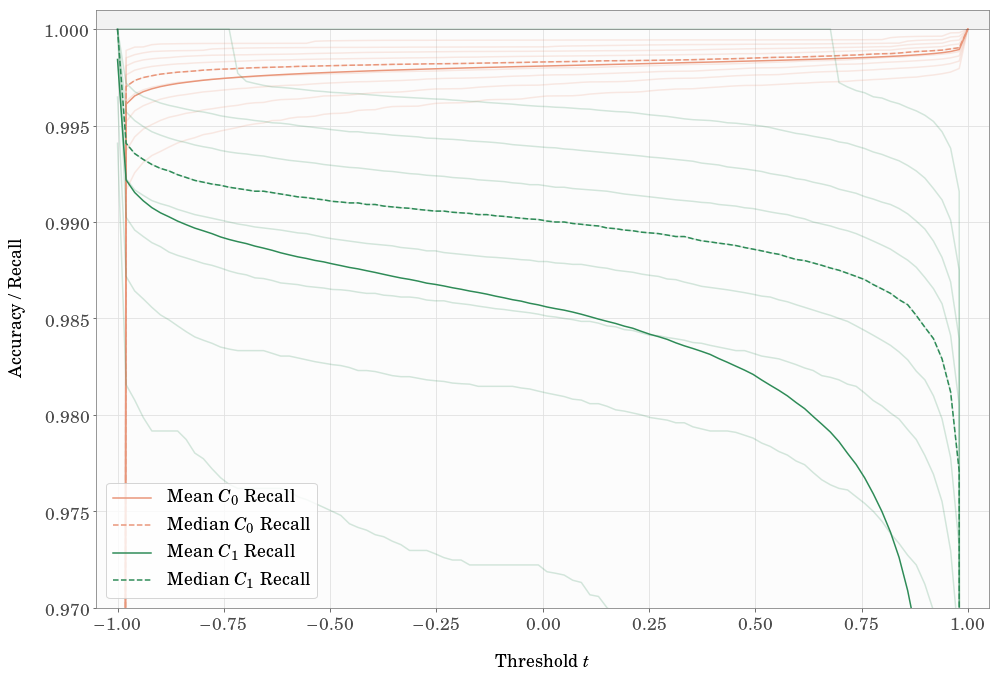

In [31]:
plt.figure(figsize=(16,11))

ax = plt.axes()

plt.setp(ax.spines.values(), color=3 * [0.5])
ax.set_facecolor(3 * [0.99])
ax.tick_params(axis='x', colors=3 * [0.3])
ax.tick_params(axis='y', colors=3 * [0.3])

#ax.axvline(x=0, linestyle='-', color='black', alpha=0.1, zorder=0, linewidth=1)
#ax.axvline(x=-0.565, linestyle='--', color='red', alpha=0.6, zorder=0)
#ax.text(-0.525, 0.985, r'$t\approx -0.565$', color = 'red', alpha=0.6)

#ax.plot(T,acc_mean, label='Mean Accuracy', color='steelblue')
#ax.fill_between(T, acc_mean + 1*acc_std, acc_mean -1*acc_std, color='steelblue', alpha=0.05, zorder=1)
#ax.fill_between(T, acc_mean + 2*acc_std, acc_mean -2*acc_std, color='steelblue', alpha=0.05, zorder=1)
#ax.fill_between(T, acc_mean + 3*acc_std, acc_mean -3*acc_std, color='steelblue', alpha=0.05, zorder=1)


ax.plot(T,acc_c0_mean, label=r'Mean $C_0$ Recall', color='darksalmon')
ax.plot(T,np.percentile(acc_c0_samples, 50, axis=0), label=r'Median $C_0$ Recall', color='darksalmon', linestyle='--')
#ax.fill_between(T, acc_c0_mean + 3*acc_c0_std, acc_c0_mean -3*acc_c0_std, color='darksalmon', alpha=0.05, zorder=1)
for i in range(1,10):
    ax.plot(T,np.percentile(acc_c0_samples, i*10, axis=0), color='darksalmon', alpha=0.2)

ax.plot(T,acc_c1_mean, label=r'Mean $C_1$ Recall', color='seagreen')
ax.plot(T,np.percentile(acc_c1_samples, 50, axis=0), label=r'Median $C_1$ Recall', color='seagreen', linestyle='--')
#ax.fill_between(T, acc_c1_mean + 1*acc_c1_std, acc_c1_mean -1*acc_c1_std, color='seagreen', alpha=0.05, zorder=1)
#ax.fill_between(T, acc_c1_mean + 2*acc_c1_std, acc_c1_mean -2*acc_c1_std, color='seagreen', alpha=0.05, zorder=1)
#ax.fill_between(T, acc_c1_mean + 3*acc_c1_std, acc_c1_mean -3*acc_c1_std, color='seagreen', alpha=0.05, zorder=1)
#ax.scatter(np.tile(T, acc_c1_samples.shape[0]), acc_c1_samples.reshape((-1)), color='seagreen', alpha=0.005, zorder=1)
for i in range(1,10):
    ax.plot(T,np.percentile(acc_c1_samples, i*10, axis=0), color='seagreen', alpha=0.2)


ax.fill_between(np.array([-2,2]), 1, 2, color=[0.95,0.95,0.95], zorder=1)
ax.axhline(y = 1, color='black', alpha=0.3,linewidth=1.0)

ax.set_ylim(0.97,1.001)
ax.set_xlim(-1.05,1.05)

ax.set_ylabel(r'Accuracy / Recall', labelpad=20)
ax.set_xlabel(r'Threshold $t$', labelpad=20)

#for i in range(10):
#    ax.axhline(y = 0.8 + i * 0.025, color='grey', alpha=0.1)
ax.axhline(y = 0.9, color='grey', alpha=0.3, linestyle='--')

ax.set_axisbelow(True)
ax.grid(color=3 * [0.88])
ax.legend(loc='lower left')


plt.savefig('precision_recall.pdf')